# Домашнее задание

1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность.

In [1866]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [1867]:
classification_data, classification_labels = datasets.make_classification(n_samples = 100,
                                                                          n_features = 2, n_informative = 2, 
                                                                          n_classes = 2, n_redundant=0, 
                                                                          n_clusters_per_class=1, random_state=5)

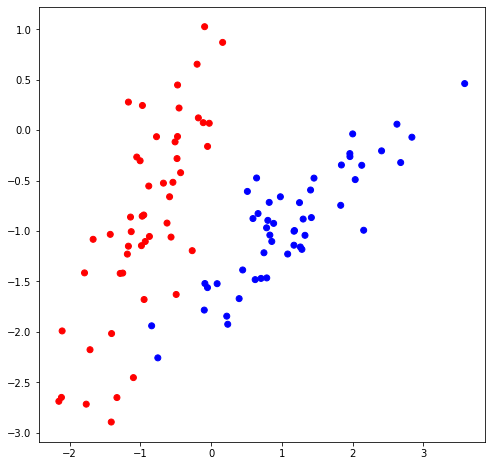

In [1868]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [1869]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [1870]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction

In [1871]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [1872]:
def quality(left_labels, right_labels, current_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [1873]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [1874]:
def find_best_split(data, labels, min_leaf):
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [1875]:
def build_tree(data, labels, min_leaf, max_leaf, depth, max_depth):

    quality, t, index = find_best_split(data, labels, min_leaf)
    
    global leaf_counter
    global node_counter

    if quality == 0:
        leaf_counter += 1
        return Leaf(data, labels)
    
    if max_depth is not None and depth >= max_depth:
        leaf_counter += 1
        return Leaf(data, labels)
    
    if max_leaf is not None:
        if leaf_counter <= max_leaf:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            node_counter += 1
            true_branch = build_tree(true_data, true_labels, min_leaf, max_leaf-leaf_counter, depth, max_depth)
            false_branch = build_tree(false_data, false_labels, min_leaf, max_leaf-leaf_counter, depth, max_depth)
        elif leaf_counter > max_leaf:
            return Leaf(data, labels)
    else:
        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        node_counter += 1
        true_branch = build_tree(true_data, true_labels, min_leaf, max_leaf, depth, max_depth)
        false_branch = build_tree(false_data, false_labels, min_leaf, max_leaf, depth, max_depth)
    
    return Node(index, t, true_branch, false_branch)

In [1876]:
def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [1877]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [1878]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)

In [1879]:
leaf_counter = 0
node_counter = 0

my_tree = build_tree(train_data, train_labels, min_leaf=1, max_leaf=100, depth=3, max_depth=None)
print(leaf_counter)
print(node_counter)

6
5


In [1880]:
def print_tree(node, spacing=''):
    if isinstance(node, Leaf):
        print(spacing + 'Прогноз:', node.prediction)
        return

    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + '  ')

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + '  ')
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.8411814419026544
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [1881]:
train_answers = predict(train_data, my_tree)

In [1882]:
answers = predict(test_data, my_tree)

In [1883]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [1884]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [1885]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

Text(0.5, 1.0, 'Test accuracy=96.67')

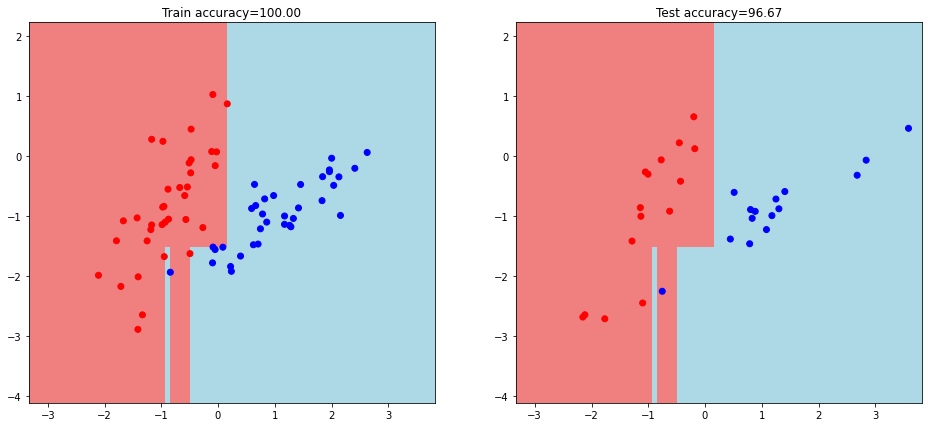

In [1886]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')